# Exploring the effect of class imbalance on model performance

Starting with the Titanic dataset as a balanced one, we will make the training data more and more imbalanced to show the effects of trying to train with fewer and fewer positive samples.

In [1]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from collections import Counter

%matplotlib inline

from src.preprocessing import preprocessor_pipeline, rebalance_dataset
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
)

%load_ext lab_black

In [2]:
with open("src/params.json", "r") as file:
    model_params = json.load(file)

In [4]:
params = model_params["model_parameters"]

## Load data and split into train/val

In [5]:
train_df = pd.read_csv("data/train.csv")

train_df, val_df = train_test_split(
    train_df, test_size=0.1, random_state=1, stratify=train_df["Survived"]
)
train_df, val_df = (train_df.copy(), val_df.copy())

In [6]:
label = "Survived"

# Main training loop

In [53]:
ratios = [1, 1.1, 1.2, 1.3, 1.4, 1.5, 2, 3, 4, 5, 10]
ratios = [0.1 * x for x in range(10, 101)]

In [55]:
df_dict = dict()

X_train_dict = dict()
y_train_dict = dict()
model_dict = dict()
scores_dict = dict()
metrics_list = list()

# instantiate the preprocessor
preprocessor = preprocessor_pipeline(scaling=True)

# define feature types
categorical_fts = ["Pclass", "Embarked", "Sex"]
numerical_fts = ["Age", "Fare"]
input_features = numerical_fts + categorical_fts

for ratio in ratios:
    df_balanced = rebalance_dataset(train_df, label, ratio)
    df_dict[ratio] = df_balanced
    print(f"Ratio {ratio} - df shape {df_dict[ratio].shape}")

    # transform the data
    X_train_dict[ratio] = preprocessor.fit_transform(df_balanced[input_features])
    y_train_dict[ratio] = df_balanced[label].values

    # sort out the validation data
    val_tf = preprocessor.transform(val_df[input_features])
    val_y = val_df[label].values

    # train the model
    clf = RandomForestClassifier(**params)
    trained_model = clf.fit(X_train_dict[ratio], y_train_dict[ratio])
    model_dict[ratio] = trained_model

    # get the scores
    scores = clf.predict_proba(val_tf)[:, 1]
    scores_dict[ratio] = scores
    # get the true values
    y_hat = np.where(scores, 1, 0)

    # get all the metrics on the model
    metrics = {
        "model_ratio": [ratio],
        "accuracy": [accuracy_score(val_y, y_hat)],
        "precision": [precision_score(val_y, y_hat)],
        "recall": [recall_score(val_y, y_hat)],
    }

    metrics_df = pd.DataFrame.from_dict(data=metrics, orient="columns")
    metrics_list.append(metrics_df)

metrics_df = pd.concat(metrics_list)
metrics_df.to_csv("data/metrics.csv", index=False)
with open("data/scores.json", "w") as f:
    json.dump({k: scores_dict[k].tolist() for k in scores_dict.keys()}, f)

Ratio 1.0 - df shape (614, 12)
Ratio 1.1 - df shape (645, 12)
Ratio 1.2000000000000002 - df shape (675, 12)
Ratio 1.3 - df shape (706, 12)
Ratio 1.4000000000000001 - df shape (737, 12)
Ratio 1.5 - df shape (767, 12)
Ratio 1.6 - df shape (798, 12)
Ratio 1.7000000000000002 - df shape (785, 12)
Ratio 1.8 - df shape (768, 12)
Ratio 1.9000000000000001 - df shape (754, 12)
Ratio 2.0 - df shape (741, 12)
Ratio 2.1 - df shape (729, 12)
Ratio 2.2 - df shape (719, 12)
Ratio 2.3000000000000003 - df shape (709, 12)
Ratio 2.4000000000000004 - df shape (700, 12)
Ratio 2.5 - df shape (692, 12)
Ratio 2.6 - df shape (684, 12)
Ratio 2.7 - df shape (677, 12)
Ratio 2.8000000000000003 - df shape (670, 12)
Ratio 2.9000000000000004 - df shape (664, 12)
Ratio 3.0 - df shape (659, 12)
Ratio 3.1 - df shape (653, 12)
Ratio 3.2 - df shape (648, 12)
Ratio 3.3000000000000003 - df shape (644, 12)
Ratio 3.4000000000000004 - df shape (639, 12)
Ratio 3.5 - df shape (635, 12)
Ratio 3.6 - df shape (631, 12)
Ratio 3.7 - d

In [9]:
print(classification_report(val_y, y_hat))
print(confusion_matrix(val_y, y_hat))

              precision    recall  f1-score   support

           0       0.83      0.80      0.81        55
           1       0.70      0.74      0.72        35

    accuracy                           0.78        90
   macro avg       0.77      0.77      0.77        90
weighted avg       0.78      0.78      0.78        90

[[44 11]
 [ 9 26]]


In [56]:
metrics_df

,model_ratio,accuracy,precision,recall
0,1.0,0.411111,0.395349,0.971429
0,1.1,0.400000,0.390805,0.971429
0,1.2,0.422222,0.397590,0.942857
0,1.3,0.455556,0.414634,0.971429
0,1.4,0.411111,0.395349,0.971429
...,...,...,...,...
0,9.6,0.655556,0.538462,0.800000
0,9.7,0.677778,0.555556,0.857143
0,9.8,0.588889,0.485294,0.942857
0,9.9,0.711111,0.588235,0.857143


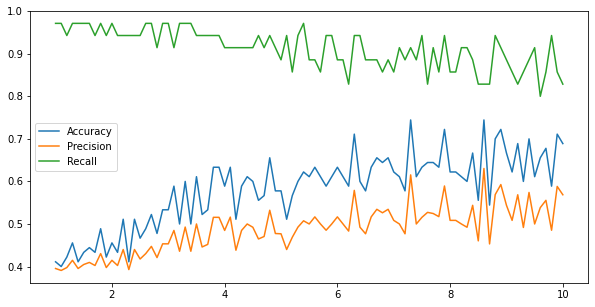

In [60]:
fig = plt.figure(figsize=(10, 5))
plt.plot(metrics_df["model_ratio"], metrics_df["accuracy"], label="Accuracy")
plt.plot(metrics_df["model_ratio"], metrics_df["precision"], label="Precision")
plt.plot(metrics_df["model_ratio"], metrics_df["recall"], label="Recall")
plt.legend()
plt.show()